# **Finding Lane Lines on the Road** 

Run the cells below to import some packages.

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os
import math

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
# helper functions

def filter_color(img, masks):
    if len(masks) == 0:
        return
    
    combined_mask = masks[0]
    for i in range(1, len(masks)):
        combined_mask = cv2.bitwise_or(combined_mask, masks[i])
    return cv2.bitwise_and(img, img, mask=combined_mask)

def yellow_mask(img):
    return cv2.inRange(img, np.array([65, 80, 80], np.uint8), np.array([105, 255, 255], np.uint8))
    #return cv2.inRange(img, np.array([65, 180, 180], np.uint8), np.array([105, 255, 255], np.uint8))

def white_mask(img):
    return cv2.inRange(img, np.array([0, 0, 205], np.uint8), np.array([255, 100, 255], np.uint8))
    
def hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def line_eqX(X, line):
    (x1, y1, x2, y2) = line
    m = (y2 - y1) / (x2 - x1)
    return m * (X - x1) + y1

def line_eqY(Y, line):
    (x1, y1, x2, y2) = line
    m = (y2 - y1) / (x2 - x1)
    return (Y - y1) / m + x1

def extend_line(line, imshape):
    return np.array([-1, line_eqX(-1, line), imshape[1] + 5, line_eqX(imshape[1] + 5, line)], dtype=np.int32)

def avg_line(lines):
    x1 = int(sum(line[0] for line in lines)/len(lines))
    y1 = int(sum(line[1] for line in lines)/len(lines))
    x2 = int(sum(line[2] for line in lines)/len(lines))
    y2 = int(sum(line[3] for line in lines)/len(lines))
    return (x1, y1, x2, y2)
    
def combine_lines(line1, line2, coeff):
    (x1, y1, x2, y2) = line1
    (a1, b1, a2, b2) = line2
    return (coeff * x1 + (1 - coeff) * a1,
            coeff * y1 + (1 - coeff) * b1,
            coeff * x2 + (1 - coeff) * a2,
            coeff * y2 + (1 - coeff) * b2)

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        x1,y1,x2,y2 = extend_line(line, img.shape)
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def display_images(images, grayscale = False):
    fig = plt.figure()
    fig.set_figheight(35)
    fig.set_figwidth(35)
    for i in range(len(images)):
        fig.add_subplot(len(images), 1, i + 1)
        if grayscale:
            plt.imshow(images[i], cmap='gray')
        else:
            plt.imshow(images[i])

In [4]:
# main code
class VideoLaneFinder:
    def __init__(self):
        self.init_values()
        self.frame_lane_finder = ImageLaneFinder()

    def init_values(self):
        self.prev_left = None
        self.prev_right = None
    
    def determine_left(self, line, imshape, coeff = 0):
        self.prev_left = line if not self.prev_left else combine_lines(self.prev_left, line, coeff)
        return self.prev_left

    def determine_right(self, line, imshape, coeff = 0):
        self.prev_right = line if not self.prev_right else combine_lines(self.prev_right, line, coeff)
        return self.prev_right
    
    def process_frame(self, image):
        left_line, right_line = self.frame_lane_finder.locate_lanes(image)
        
        left_lane = self.determine_left(left_line, image.shape, 0.9)
        right_lane = self.determine_right(right_line, image.shape, 0.9)
        
        return self.frame_lane_finder.draw_lanes(image, (left_lane, right_lane))
        
    def find_lanes(self, video):
        self.init_values()
        output_video = video.fl_image(self.process_frame)
        return output_video
        
class ImageLaneFinder:
    def locate_lanes(self, image):
        hsv_img = hsv(image)
        blurred = gaussian_blur(hsv_img, 5)
        filtered = filter_color(blurred, [yellow_mask(blurred), white_mask(blurred)])
        edges = canny(filtered, 75, 150)

        imshape = image.shape
        vertices = np.array([[(0,imshape[0]),(imshape[1]/2.1, imshape[0]/1.65), (imshape[1]*2/3.7, imshape[0]/1.65), (imshape[1],imshape[0])]], dtype=np.int32)
        masked = region_of_interest(edges, vertices)

        lines = cv2.HoughLinesP(masked, 1, np.pi/90, 5, np.array([]), minLineLength=50, maxLineGap=150)

        left_lines, right_lines = self.divide_lines(lines, imshape)
        return avg_line(left_lines), avg_line(right_lines)
    
    def draw_lanes(self, image, lanes):
        imshape = image.shape
        black_image = np.zeros((imshape[0],imshape[1],3), np.uint8)
        draw_lines(black_image, lanes, color=[255, 0, 0], thickness=10)
        
        vertices = np.array([[(0,imshape[0]),(imshape[1]/2.15, imshape[0]/1.65), (imshape[1]*2/3.65, imshape[0]/1.65), (imshape[1],imshape[0])]], dtype=np.int32)
        new_masked = region_of_interest(black_image, vertices)
        
        return weighted_img(new_masked, image, α=0.8, β=0.6, λ=0.5)
    
    def find_lanes(self, image):
        return self.draw_lanes(image, self.locate_lanes(image))
    
    def divide_lines(self, lines, imshape):
        left_lane = []
        right_lane = []
        for line in lines:
            #((y2-y1)/(x2-x1))
            x1,y1,x2,y2 = line[0]
            slope = ((y2-y1)/(x2-x1))
            if slope > 0.4 and slope < 1 and x1 > imshape[1]/2.0:
                left_lane.append(line[0])
            elif slope < -0.4 and slope > -1 and x1 < imshape[1]/2.0:
                right_lane.append(line[0])
        return (left_lane, right_lane)


## Test on Images

Running our solution on all test_images.

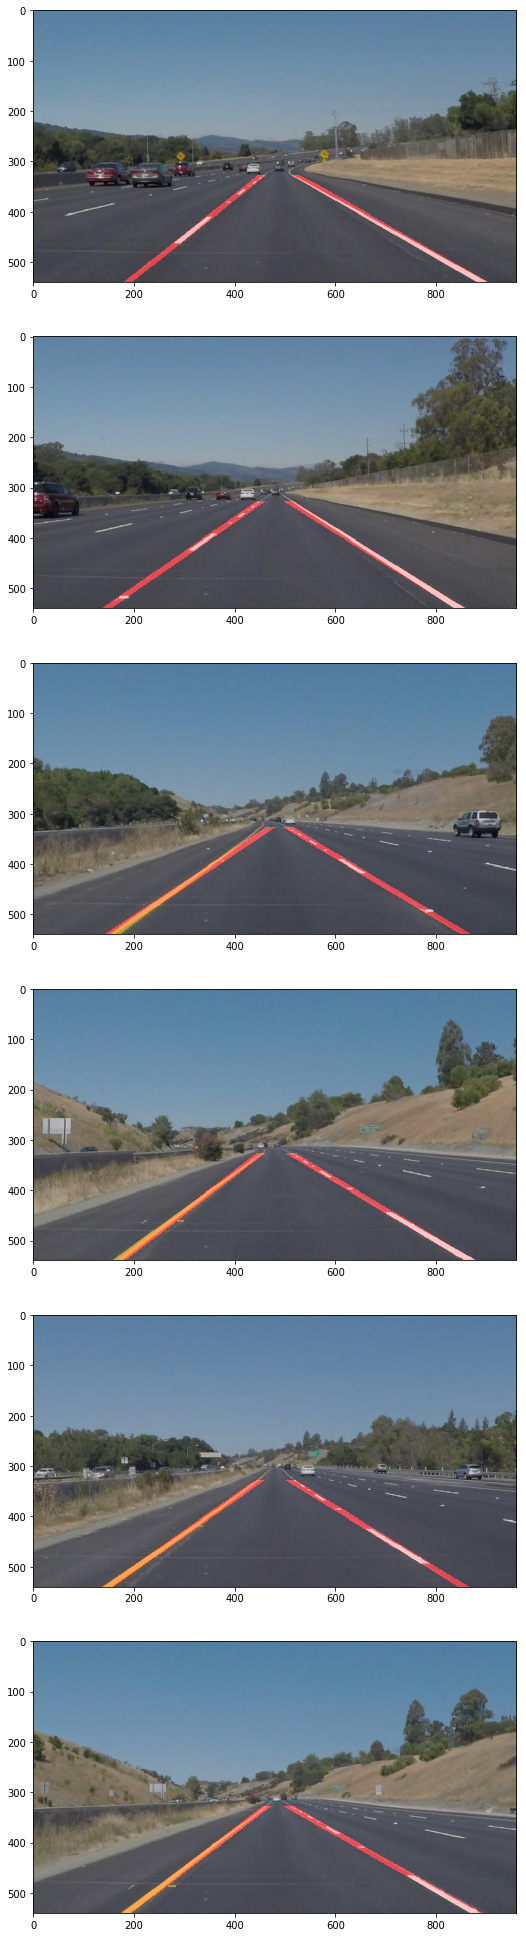

In [5]:
all_image_names = os.listdir("test_images/")
all_images = [np.copy(mpimg.imread("test_images/" + image_name)) for image_name in all_image_names]
image_lane_finder = ImageLaneFinder()
gray_images = [image_lane_finder.find_lanes(image) for image in all_images]
display_images(gray_images, grayscale=True)

## Test on Videos

In [6]:
video_lane_finder = VideoLaneFinder()

Let's try the one with the solid white lane on the right first ...

In [7]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = video_lane_finder.find_lanes(clip1)
white_clip.write_videofile(white_output, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:03<00:00, 55.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 



Now for the one with the solid yellow lane on the left. This one's more tricky!

In [8]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = video_lane_finder.find_lanes(clip2)
yellow_clip.write_videofile(yellow_output, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:14<00:00, 46.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 



## Reflections

The biggest problem seems to be the parameter tweaking. I can tweak hough lines params to work very well for one video, but it might fail for the other. I can tweak yellow and white color ranges for color filtering, but that will certainly fail under some other lighting conditions. 

There is just a lot of variables that need to be tweaked for different road and lighting conditions, so this kind of approach doesn't seem to generalize well. I am absolutely not confident that this would work on a random new video.

A reasonable approach would be to do some sort of parameter exploration, starting off with very conservative parameters, and, if failing to find a lane, loosening up the parameters, but this doesn't seem very performant.

Another possiblity is figuring out if it's possible to calibrate the params at the beginning of the video, but this might again fail in changing conditions.

## Optional Challenge

The following video is more challenging than the previous two because:
  1. the top of the car is visible at the bottom of the video
  2. The road has been repaired, resulting in a sharp change of road color in two places, for which the gradient will be high
  3. There are shadows from trees that result in many noise lines
  4. The light section of the repaired road has a horrible contrast compared to the yellow lane line, which required some special tweaking.
  
What helped to make this video work is to pre-filter the images with yellow and white filters. This got rid of the road repair transition line. Additionally, we also do a weighted sum of the lane line from the previous frame and a current frame, to help with jitters.

In [9]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = video_lane_finder.find_lanes(clip2)
challenge_clip.write_videofile(challenge_output, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:13<00:00, 21.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

